# Traffic Signs Recognition using CNN

In [152]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
import random
from china.china_dataset_reader import load_traffic_sign_dataset
from india.india_dataset_reader import load_india_dataset


code reference:

https://github.com/deepak2233/Traffic-Signs-Recognition-using-CNN-Keras/blob/main/Model/Traffic%20Signs%20Recognition%20using%20CNN%20%26%20Keras%20with%2098%25%20Accuracy.ipynb

https://www.kaggle.com/code/osamaabidoo/98-accuracy-on-german-traffic-sign-recognition

## GTSRB Dataset Overview

In [153]:
# Train.csv
train_csv_path = os.getcwd() + "\dataset\Train.csv"
train_df = pd.read_csv(train_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
train_df.head()

,Width,Height,ClassId,Path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


In [154]:
# Test.csv
test_csv_path = os.getcwd() + "\dataset\Test.csv"
test_df = pd.read_csv(test_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
test_df.head()

,Width,Height,ClassId,Path
0,53,54,16,Test/00000.png
1,42,45,1,Test/00001.png
2,48,52,38,Test/00002.png
3,27,29,33,Test/00003.png
4,60,57,11,Test/00004.png


In [155]:
# GTSRB Label Overview (from Kaggle)
GTSRB_classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Load the GTSRB


In [156]:
train_data = [] # X_train
train_labels = [] # X_test
classes = 43
train_path = os.getcwd() + "\dataset\Train"

for i in os.listdir(train_path):
    dir = train_path + '/' + i
    if os.path.isdir(dir):
        for j in os.listdir(dir):
            try:
                img_path = dir+ '/' +j
                img = cv2.imread(img_path,-1)
                # resize all images to 30,30
                img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
                train_data.append(img)
                train_labels.append(i)
            except Exception as e:
                print(e)    
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

(39209, 30, 30, 3) (39209,)


In [157]:
test_data = [] # y_train
test_labels = [] # y_test
test_path = os.getcwd() + "\dataset\Test"

for index, row in test_df.iterrows():
    img_path = os.getcwd() + "\dataset/" + row['Path']
    img = cv2.imread(img_path, -1)
    img = cv2.resize(img, (30,30), interpolation=cv2.INTER_NEAREST)
    test_data.append(img)
    test_labels.append(row['ClassId'])

test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


## Visualize Train Data in GTSRB

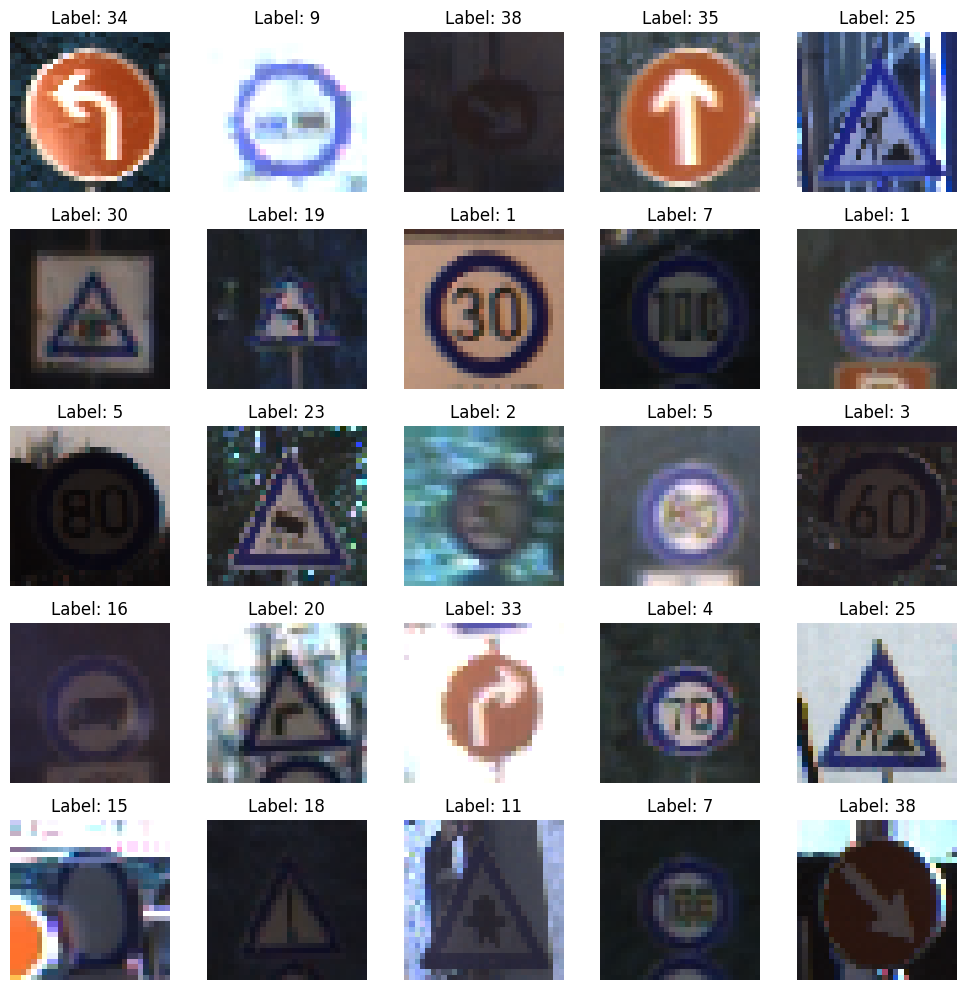

In [158]:
random_indices = random.sample(range(len(train_data)), 25)
# randomly plot 25 images from train_data[]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = random_indices[i * 5 + j]
        # Display the image
        axs[i, j].imshow(train_data[index])
        axs[i, j].axis('off')
        # Display the corresponding label
        axs[i, j].set_title(f"Label: {train_labels[index]}")
plt.tight_layout()
plt.show()


## Load Chinese Traffic Sign Dataset

In [159]:
china_images, china_categories = load_traffic_sign_dataset()
print(china_images.shape, china_categories.shape)

CSV Path: D:\mydata\Github\comp9444-project\china\annotations.csv
(6164, 30, 30, 3) (6164,)


## Data augmentation functions

In [160]:
# rotates each image by -10 degrees (left) and 10 degrees (right) and then concatenates 
# the original and augmented datasets along with their corresponding labels. 
def rotate_augmentation(images, labels):
    augmented_data = []
    augmented_labels = []

    for img, label in zip(images, labels):
        # Rotate left
        rotated_left = rotate_image(img, angle=-10)
        augmented_data.append(rotated_left)
        augmented_labels.append(label)

        # Rotate right
        rotated_right = rotate_image(img, angle=10)
        augmented_data.append(rotated_right)
        augmented_labels.append(label)

    augmented_data = np.concatenate([images, augmented_data])
    augmented_labels = np.concatenate([labels, augmented_labels])

    return augmented_data, augmented_labels

def rotate_image(image, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST)
    return rotated_image

china_images, china_categories= rotate_augmentation(china_images, china_categories)
print(china_images.shape, china_categories.shape)

(18492, 30, 30, 3) (18492,)


In [161]:
# applies random zooming (by 0.15) or width shifting (by 0.1) or height shifting (by 0.1) to each image and then concatenates 
# the original and augmented datasets along with their corresponding labels. 
def random_zoom_or_shift(images, labels):
    augmented_data = []
    augmented_labels = []

    for img, label in zip(images, labels):
        # Randomly choose augmentations types
        num_augmentations = np.random.randint(1, 4)  # Choose between 1 to 3 augmentations
        augmentation_types = np.random.choice(['zoom', 'width_shift', 'height_shift'], size=num_augmentations, replace=True)
        augmented_img = img.copy()
        for augmentation_type in augmentation_types:
            if augmentation_type == 'zoom':
                zoom_factor = np.random.uniform(1 - 0.15, 1 + 0.15)
                augmented_img = zoom_image(augmented_img, zoom_factor)
            elif augmentation_type == 'width_shift':
                width_shift_factor = np.random.uniform(-0.1, 0.1)
                augmented_img = shift_width(augmented_img, width_shift_factor)
            elif augmentation_type == 'height_shift':
                height_shift_factor = np.random.uniform(-0.1, 0.1)
                augmented_img = shift_height(augmented_img, height_shift_factor)
        augmented_img = cv2.resize(augmented_img, (30, 30), interpolation=cv2.INTER_NEAREST)
        augmented_data.append(augmented_img)
        augmented_labels.append(label)       

    augmented_data = np.concatenate([images, augmented_data])
    augmented_labels = np.concatenate([labels, augmented_labels])

    return augmented_data, augmented_labels

def zoom_image(image, factor):
    height, width = image.shape[:2]
    new_height, new_width = int(height * factor), int(width * factor)
    zoomed_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    return zoomed_image

def shift_width(image, factor):
    height, width = image.shape[:2]
    shift_pixels = int(width * factor)
    shifted_image = np.roll(image, shift_pixels, axis=1)
    return shifted_image

def shift_height(image, factor):
    height, width = image.shape[:2]
    shift_pixels = int(height * factor)
    shifted_image = np.roll(image, shift_pixels, axis=0)
    return shifted_image


china_images, china_categories = random_zoom_or_shift(china_images, china_categories)
print(china_images.shape, china_categories.shape)


(36984, 30, 30, 3) (36984,)


In [162]:
def plot_classes_with_images(images, categories, num_classes=5, images_per_row=7):
    unique_categories = np.unique(categories)
    num_rows = -(-num_classes // images_per_row)  # Ceil division to calculate the number of rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))

    for i in range(num_rows):
        for j in range(images_per_row):
            index = i * images_per_row + j
            if index < num_classes:
                class_category = unique_categories[index]
                class_images = images[categories == class_category]

                # Randomly select an image from the class
                random_image = random.choice(class_images)

                axes[i, j].imshow(random_image)
                axes[i, j].set_title(f'Class {class_category}')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots

    plt.show()


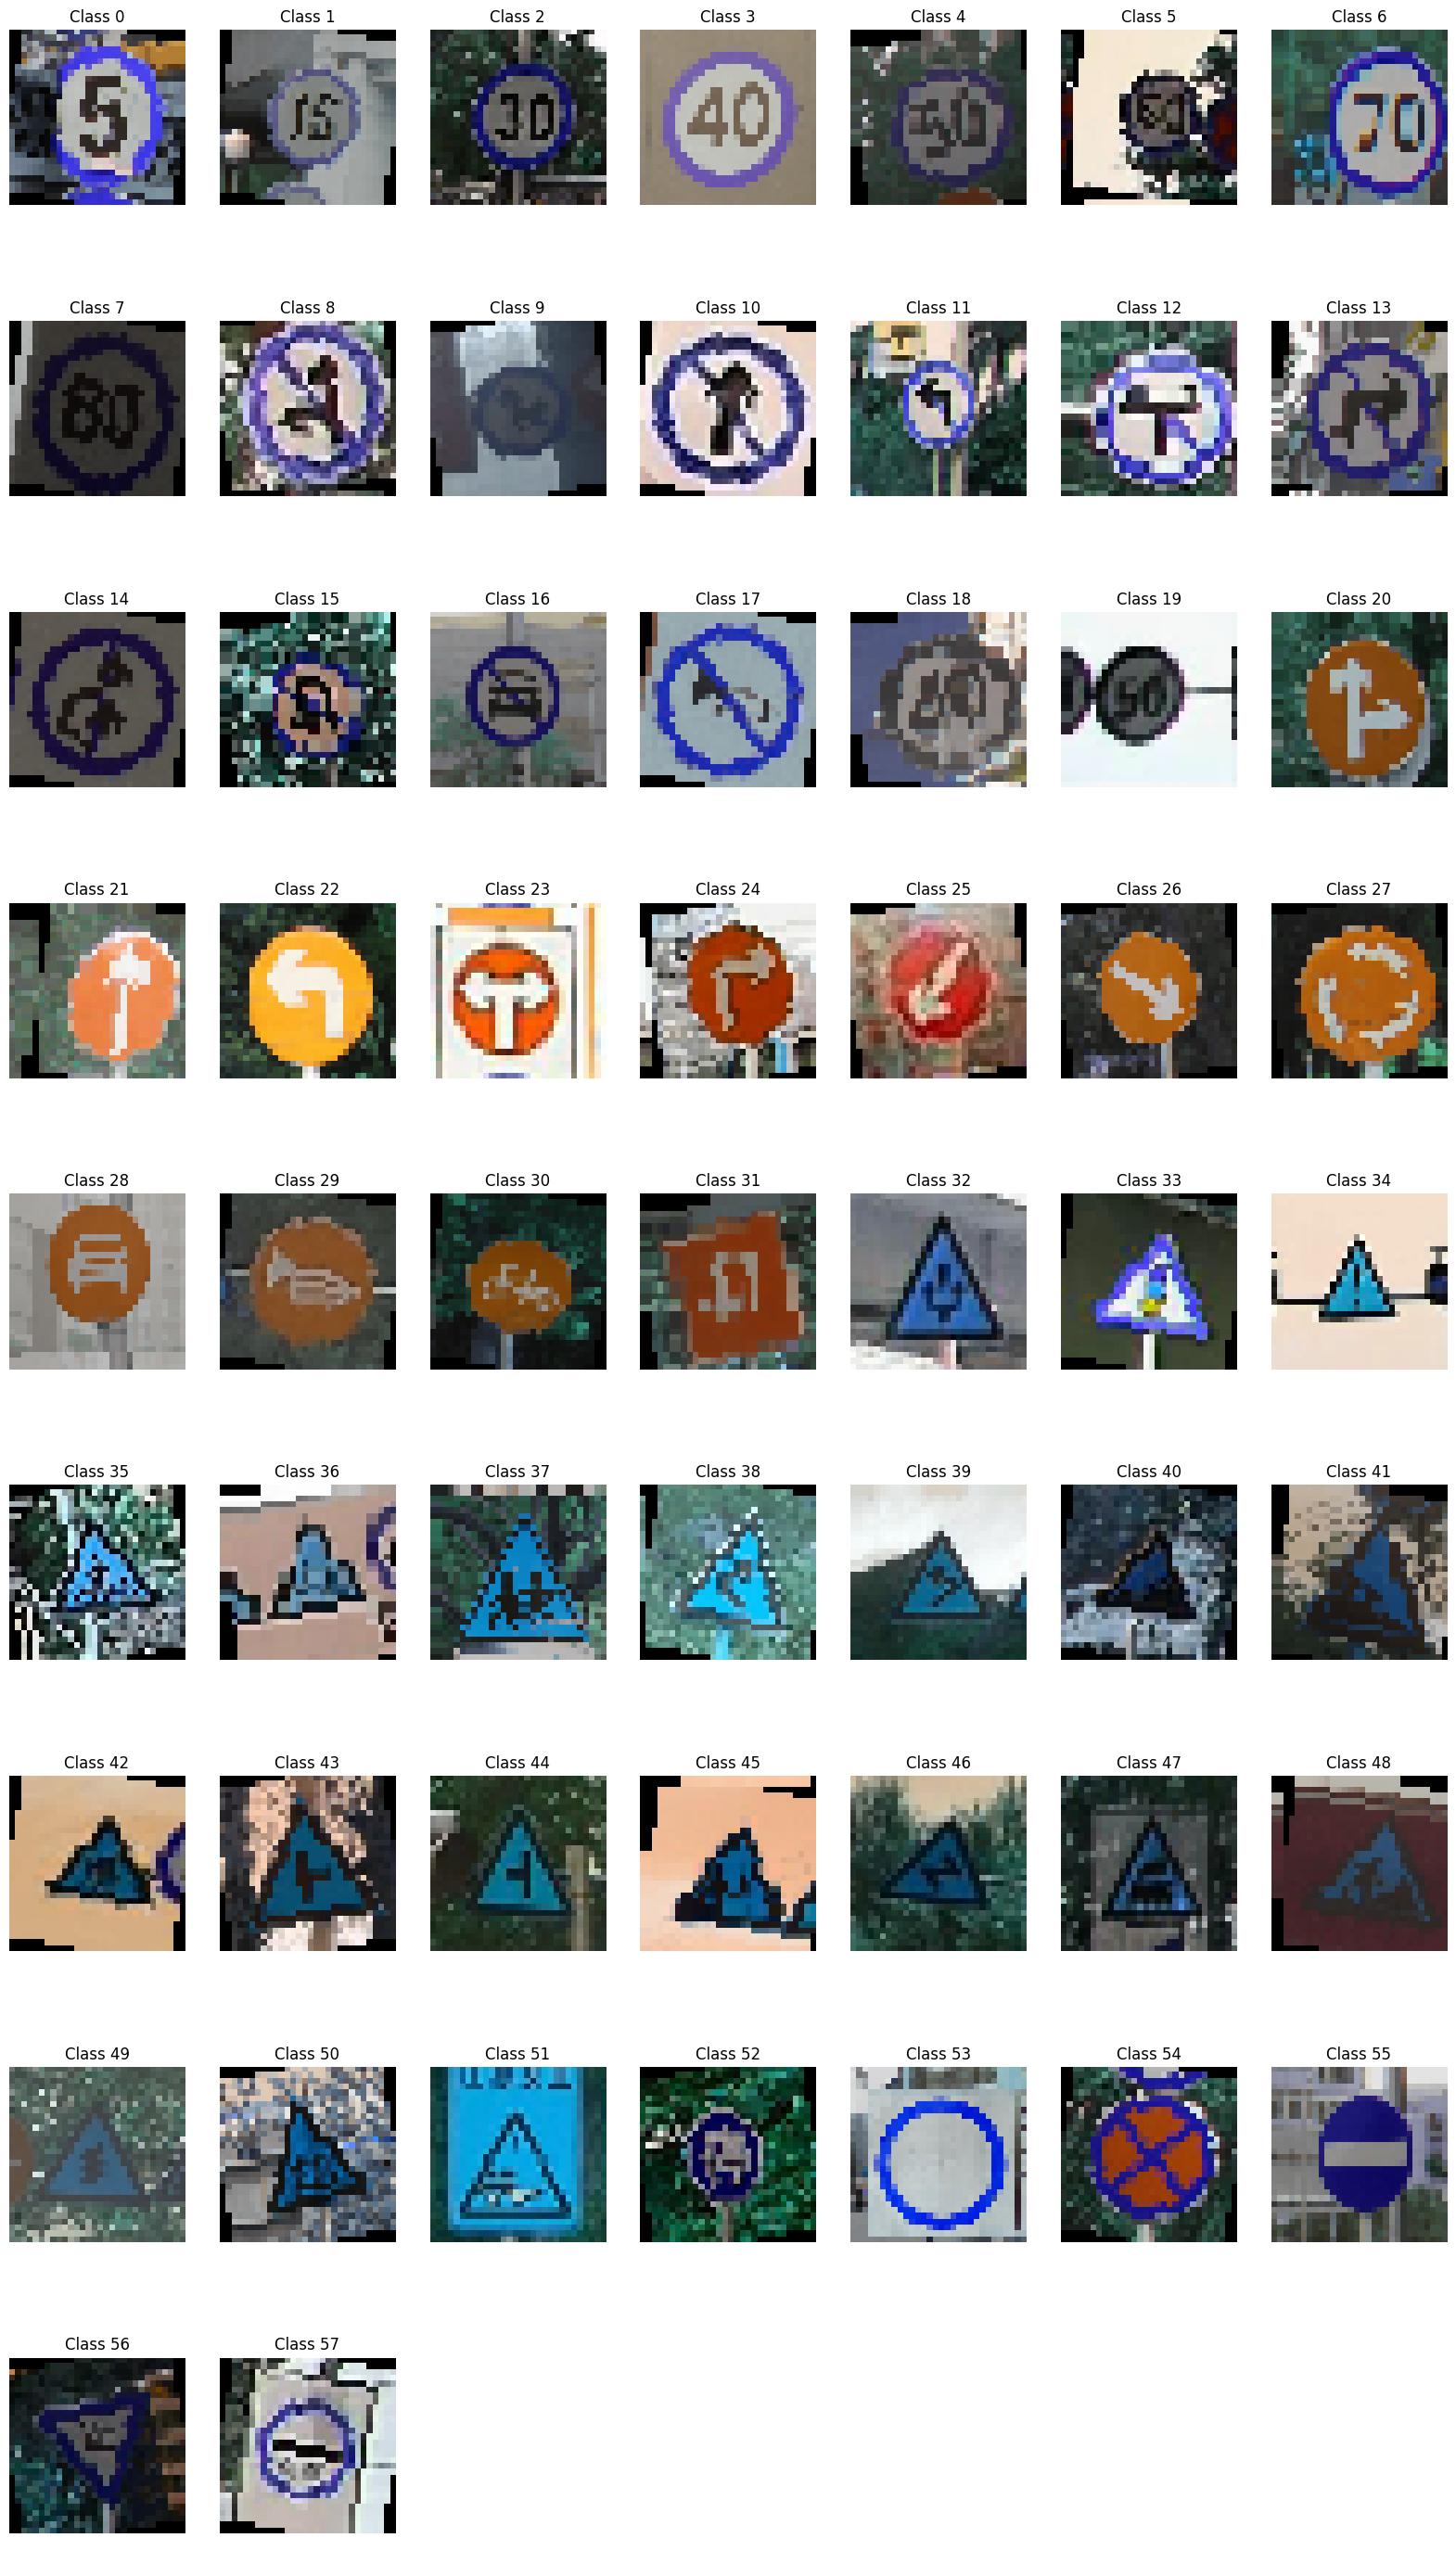

In [163]:
plot_classes_with_images(china_images, china_categories, 58)

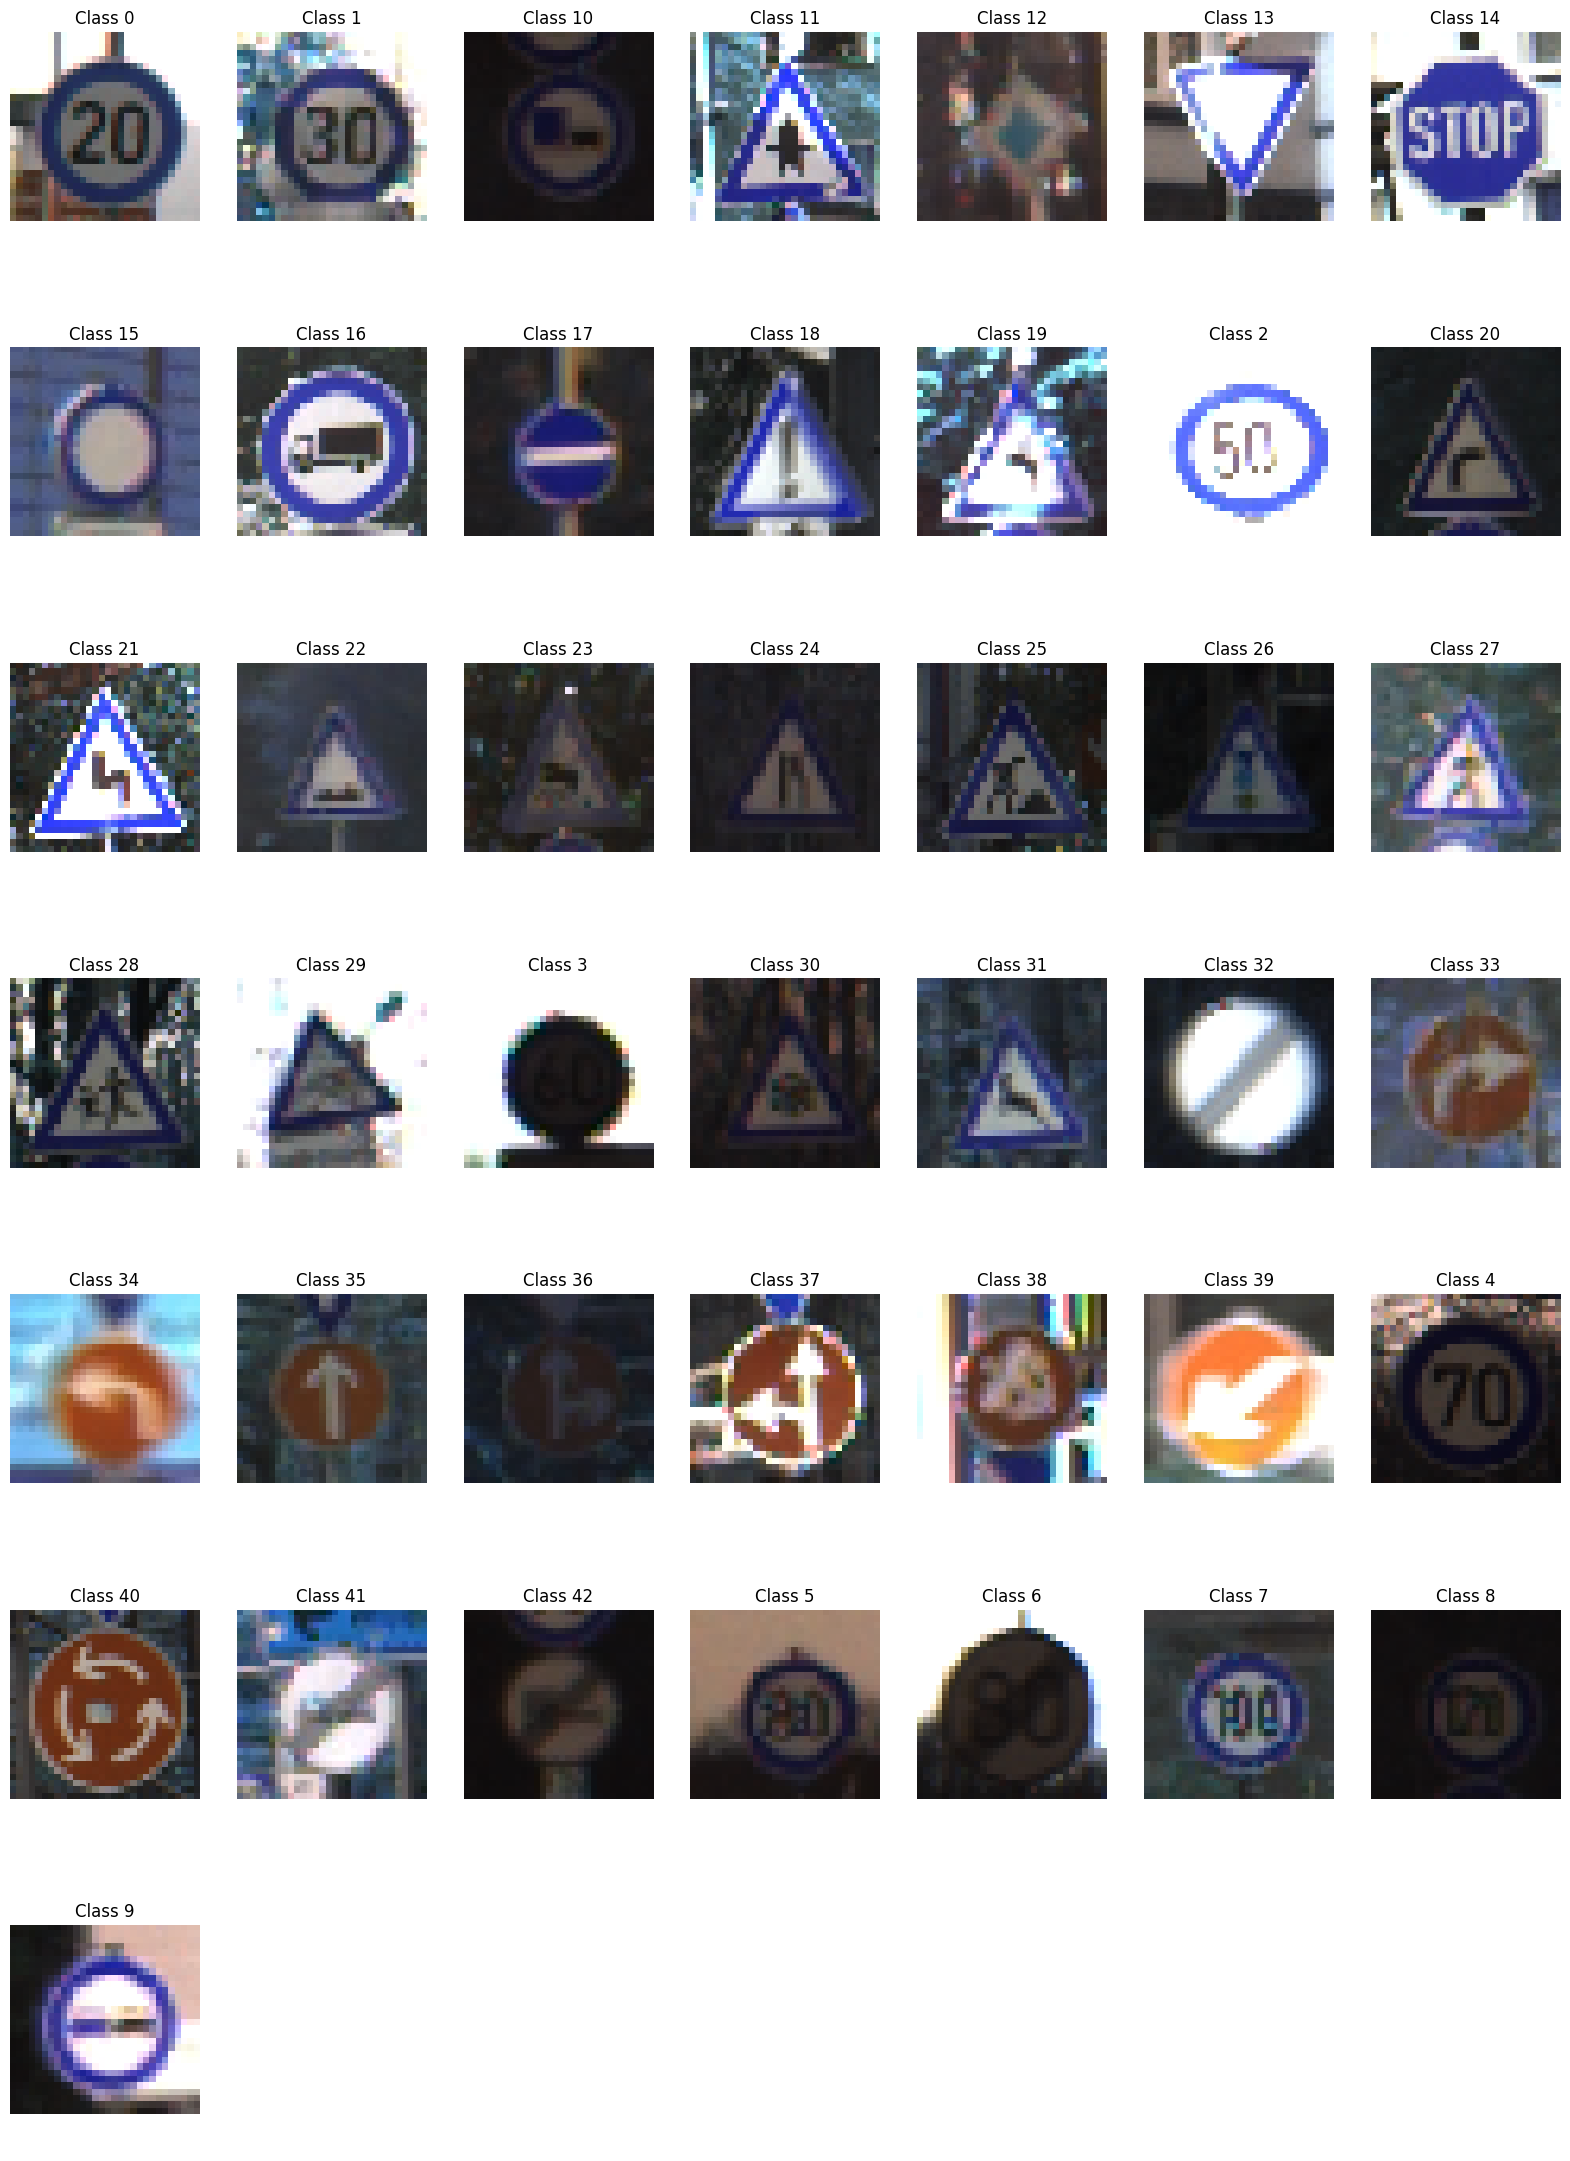

In [164]:
plot_classes_with_images(train_data, train_labels, 43)

In [165]:
# manually label the classes in chinese dataset
# labelled based on the name on https://en.wikipedia.org/wiki/Road_signs_in_China
china_classes = { 0:'Speed limit (5km/h)',
                1:'Speed limit (15km/h)', 
                2:'Speed limit (30km/h)', 
                3:'Speed limit (40km/h)', 
                4:'Speed limit (50km/h)', 
                5:'Speed limit (60km/h)', 
                6:'Speed limit (70km/h)', 
                7:'Speed limit (80km/h)', 
                8:'No proceed straight and left turns', 
                9:'No proceed straight and right turns', 
                10:'No proceed straight', 
                11:'No left turn', 
                12:'No left and right turns', 
                13:'No right turn', 
                14:'No overtaking', 
                15:'No U-turns', 
                16:'No motor vehicles', 
                17:'No honking', 
                18:'End of speed limit (40km/h)', 
                19:'End of speed limit (50km/h)', 
                20:'Go straight or right', 
                21:'Ahead only', 
                22:'Turn left ahead', 
                23:'Go left or right', 
                24:'Turn right ahead', 
                25:'Keep left', 
                26:'Keep right', 
                27:'Roundabout mandatory', 
                28:'Lane for automobile', 
                29:'Honking', 
                30:'Bicycles only',
                31:'U-turn', 
                32:'Turn left and/or right to detour', 
                33:'Traffic signals', 
                34:'General caution', 
                35:'Pedestrian crossing ahead', 
                36:'Bicycles crossing', 
                37:'Children crossing', 
                38:'Dangerous curve right', 
                39:'Dangerous curve left', 
                40:'Steep descent', 
                41:'Steep ascent', 
                42:'Tunnel ahead', # not sure
                43:'Side road junction ahead on the right',
                44:'Side road junction ahead on the left',
                45:'Cross-village road',
                46:'Double curve, with turn right first, then left', # GTSRB has a general version double curve, should i merge them?
                47:'Railroad crossing ahead (without safety barriers)',
                48:'Road work',
                49:'Multiple curves',
                50:'Railroad head (with safety barriers)',
                51:'Accident area',
                52:'Stop',
                53:'No vehicles',
                54:'No stopping',
                55:'No entry',
                56:'Yield',
                57:'Control' }

In [166]:
# plot_classes_with_images(merged_data, merged_labels, 78)

## Load the India Dataset 

In [167]:
India_train, India_label = load_india_dataset()
print(India_train.shape, India_label.shape)

(10584, 30, 30, 3) (10584,)


In [168]:
# Increase ths size of the dataset by using data augmentation again like the chinese dataset
India_train, India_label= rotate_augmentation(India_train, India_label)
India_train, India_label = random_zoom_or_shift(India_train, India_label)
print(India_train.shape, India_label.shape)

(63504, 30, 30, 3) (63504,)


In [169]:
# manually label 
india_classes = {
      0:'Yield',
      1:'No proceed straight',
      2:'One-way traffic',
      3:'One-way traffic',
      4:'No vehicles in both directions',
      5:'No entry for cycles',
      6:'No entry for goods vehicles',
      7:'No entry for pedestrians',
      8:'No entry for bullock carts',
      9:'No entry for hand carts',
      10:'No motor vehicles',
      11:'Height limit',
      12:'Weight limit',
      13:'Axle weight limit',
      14:'Length limit',
      15:'No left turn',
      16:'No right turn',
      17:'No overtaking',
      18:'Speed limit (90 km/h)',
      19:'Speed limit (110 km/h)',
      20:'No honking',
      21:'No parking',
      22:'No stopping',
      23:'Turn left ahead',
      24:'Turn right ahead',
      25:'Steep descent',
      26:'Steep ascent',
      27:'Road narrows on the right',
      28:'Narrow bridge',
      29:'Unprotected quay',
      30:'Road hump',
      31:'Bumpy road',
      32:'Loose gravel',
      33:'Falling rocks',
      34:'Wild animals crossing',
      35:'Crossroads',
      36:'Side road junction',
      37:'Oblique side road junction',
      38:'T-junction',
      39:'Y-junction',
      40:'Staggered side road junction',
      41:'Roundabout mandatory',
      42:'Railroad head (with safety barriers)',
      43:'Unguarded level crossing ahead',
      44:'Parking',
      45:'Bus stop'
}

## Exploratory Analysis of Data
---

### As an example, using the GTRSB dataset.

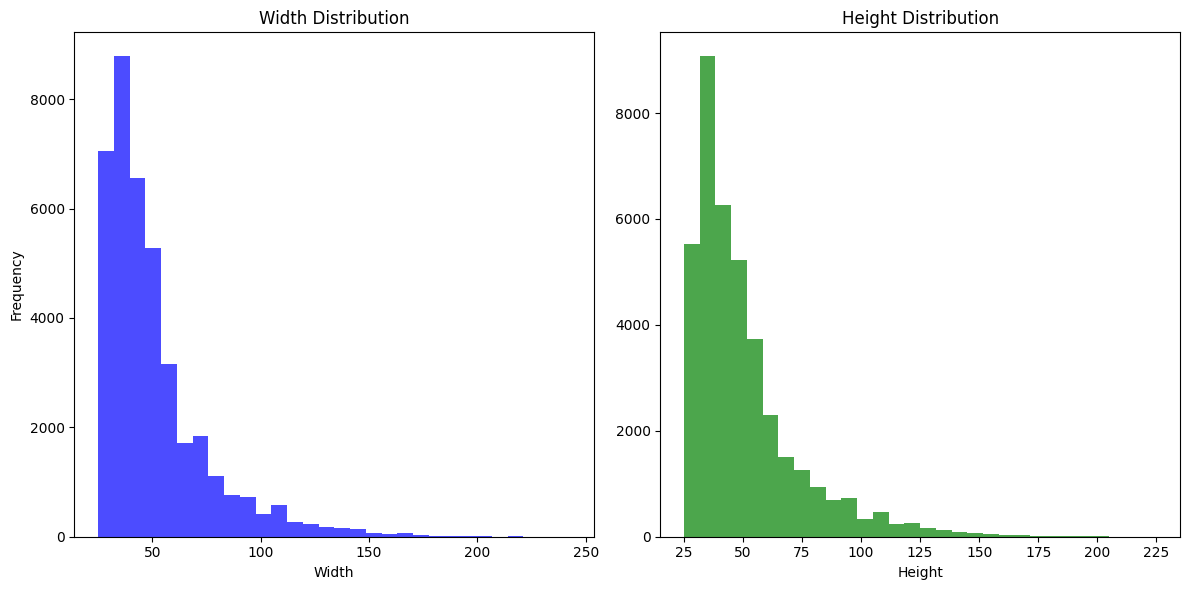

In [170]:
# Analyzing image size distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_df['Width'], bins=30, color='blue', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_df['Height'], bins=30, color='green', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height')

plt.tight_layout()  # Adjust the layout of the subgraph.
plt.show()

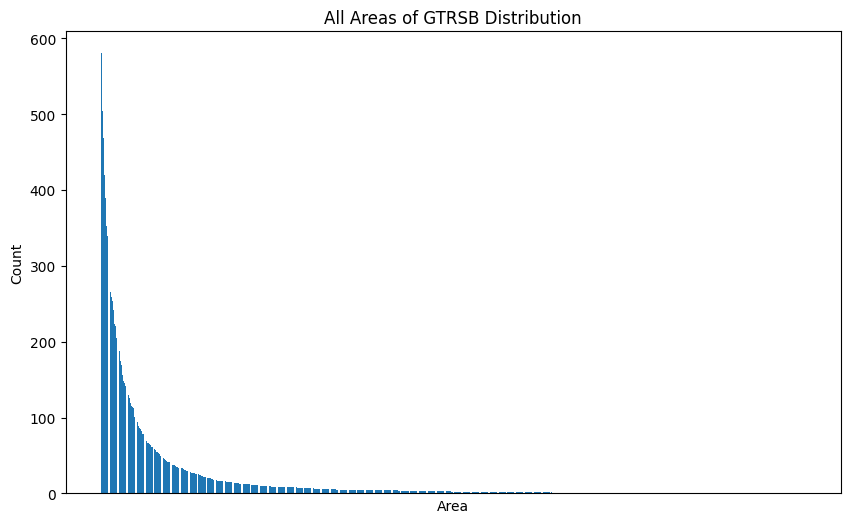

In [171]:
# Calculate the area of an image.
train_df['Area'] = train_df['Width'] * train_df['Height']

area_counts = train_df['Area'].value_counts()
area_counts = train_df['Area'].value_counts().rename_axis('Area').reset_index(name='Count')
# Visualizing the number of images corresponding to different sizes.
area_counts['Area'] = area_counts['Area'].astype(str)

unique_categories = area_counts['Area'].unique()

plt.figure(figsize=(10, 6))
plt.bar(area_counts['Area'], area_counts['Count'])
plt.xlabel('Area')
plt.ylabel('Count')
plt.title('All Areas of GTRSB Distribution')
plt.xticks([])

plt.show()

                 Area  Count
0    (570.95, 6030.0]  34752
1   (6030.0, 11435.0]   2948
2  (11435.0, 16840.0]    934
3  (16840.0, 22245.0]    345
4  (22245.0, 27650.0]    124
5  (27650.0, 33055.0]     65
6  (33055.0, 38460.0]     22
7  (38460.0, 43865.0]     11
8  (43865.0, 49270.0]      7
9  (49270.0, 54675.0]      1


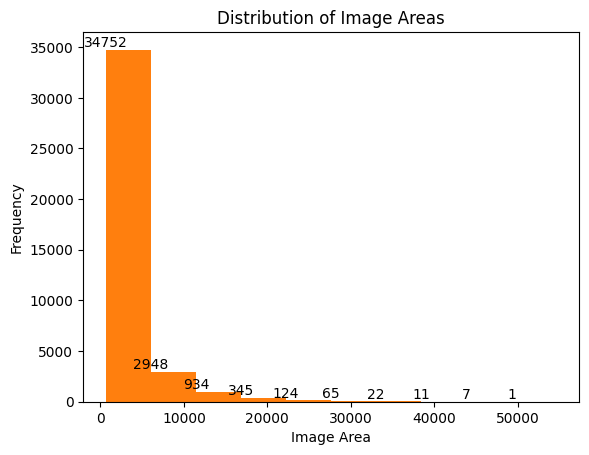

In [172]:
import pandas as pd

area_bins = pd.cut(train_df['Area'], bins=10)

area_counts = area_bins.value_counts().rename_axis('Area').reset_index(name='Count')

print(area_counts)

# Draw a histogram of the area.
plt.hist(train_df['Area'], bins=10)
# Obtain the height of each pillar.
hist, bins, _ = plt.hist(train_df['Area'], bins=10)

# Add text labels at the top of each column.
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')

plt.xlabel('Image Area')
plt.ylabel('Frequency')
plt.title('Distribution of Image Areas')

plt.show()

Looking at the distribution of image sizes, most of the images are around 750 in size, which is approximately 27×28. However, there are still some images that exceed a size of 10000, so we may need to standardize the size of the input images.

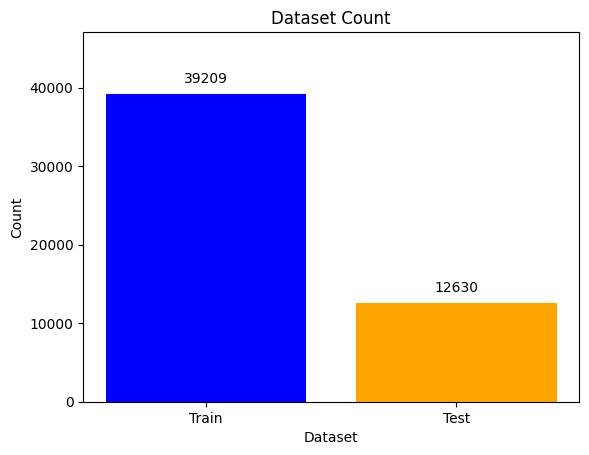

In [173]:
# Number of datasets
train_count = len(train_df)
test_count = len(test_df)
# Create a bar chart.
plt.bar(['Train', 'Test'], [train_count, test_count], color=['blue', 'orange'])
plt.title('Dataset Count')
plt.xlabel('Dataset')
plt.ylabel('Count')

# set the upper limit on the y-axis.
plt.ylim([0, max(train_count, test_count)*1.2])

# Add text labels
plt.text(0, train_count+1000, train_count, ha='center', va='bottom')
plt.text(1, test_count+1000, test_count, ha='center', va='bottom')

plt.show()

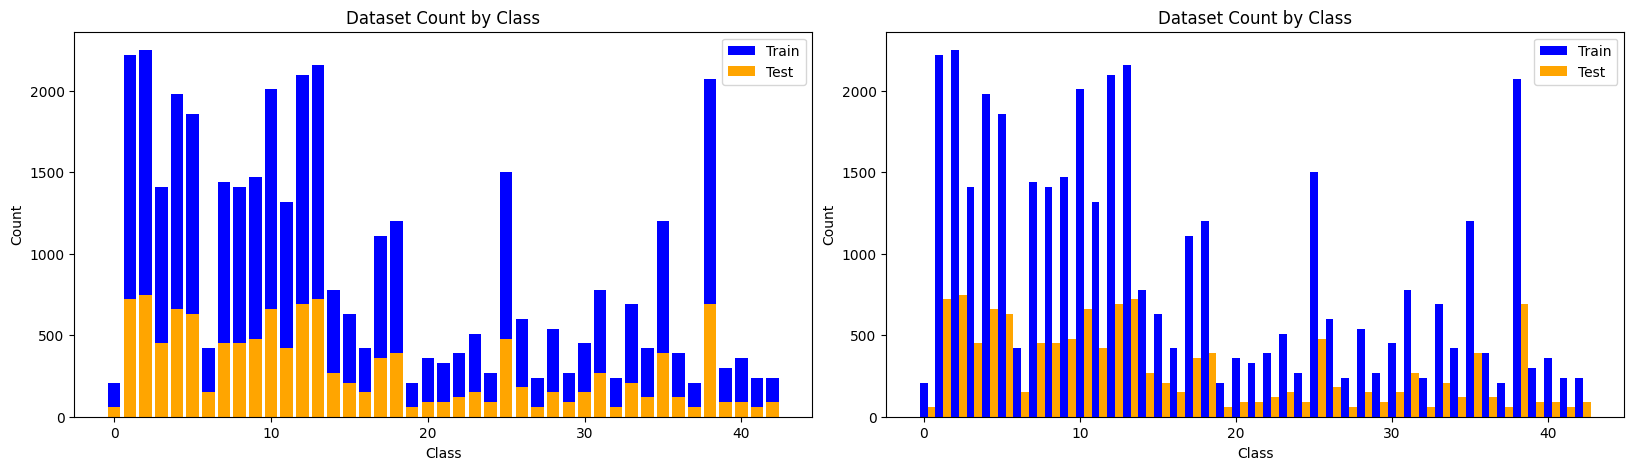

In [174]:
# Calculate the number of each category in the training set.
train_counts = train_df['ClassId'].value_counts().sort_index()
train_labels = train_counts.index.tolist()

# Calculate the number of each category in the test set.
test_counts = test_df['ClassId'].value_counts().sort_index()
test_labels = test_counts.index.tolist()
# Create a plotting area and set the arrangement of subplots to be 1 row and 2 columns.
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Draw the first subplot (proportion of training set and test set)
axs[0].bar(train_labels, train_counts, color='blue', label='Train')
axs[0].bar(test_labels, test_counts, color='orange', label='Test')
axs[0].set_title('Dataset Count by Class')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].legend()

# Draw the second subplot (number of training and testing samples)
width = 0.5
axs[1].bar(train_labels, train_counts, width, color='blue', label='Train')
axs[1].bar([x + width for x in test_labels], test_counts, width, color='orange', label='Test')
axs[1].set_title('Dataset Count by Class')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].legend()

# Adjust the spacing between subplots.
plt.subplots_adjust(wspace=0.1)

plt.show()

### Loade GTSRB & China & India As DataFrame

In [175]:
# GTRSB 
GTRSB_train_df = train_df

# China
China_train_csv_path = os.getcwd() + "\china\\annotations.csv"
China_train_df = pd.read_csv(China_train_csv_path, usecols=['category', 'file_name', 'width', 'height'])

# India
India_train_df = pd.DataFrame({'India_label': India_label})
India_train_df = India_train_df.value_counts()

In [176]:
GTRSB_train_df

,Width,Height,ClassId,Path,Area
0,27,26,20,Train/20/00020_00000_00000.png,702
1,28,27,20,Train/20/00020_00000_00001.png,756
2,29,26,20,Train/20/00020_00000_00002.png,754
3,28,27,20,Train/20/00020_00000_00003.png,756
4,28,26,20,Train/20/00020_00000_00004.png,728
...,...,...,...,...,...
39204,52,56,42,Train/42/00042_00007_00025.png,2912
39205,56,58,42,Train/42/00042_00007_00026.png,3248
39206,58,62,42,Train/42/00042_00007_00027.png,3596
39207,63,69,42,Train/42/00042_00007_00028.png,4347


In [177]:
China_train_df

,file_name,width,height,category
0,000_0001.png,134,128,0
1,000_0002.png,165,151,0
2,000_0003.png,128,122,0
3,000_0010.png,80,73,0
4,000_0011.png,186,174,0
...,...,...,...,...
6159,056_1_0018_1_j.png,122,94,56
6160,056_1_0019_1_j.png,224,207,56
6161,056_1_0020_1_j.png,128,115,56
6162,057_1_0001_1_j.png,100,95,57


In [178]:
India_train_df = pd.DataFrame({'Classes': India_label})

value_counts = India_train_df['Classes'].value_counts().rename(index=india_classes).reset_index()
value_counts.columns = ['Classes', 'Count']
value_counts

,Classes,Count
0,No honking,3606
1,No entry for bullock carts,3606
2,Parking,3600
3,No entry for cycles,1926
4,Bus stop,1320
5,Wild animals crossing,1206
6,Road narrows on the right,1206
7,Narrow bridge,1206
8,Unprotected quay,1206
9,Road hump,1206


In [179]:
print(GTRSB_train_df.info(),China_train_df.info(),India_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   ClassId  39209 non-null  int64 
 3   Path     39209 non-null  object
 4   Area     39209 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6164 entries, 0 to 6163
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  6164 non-null   object
 1   width      6164 non-null   int64 
 2   height     6164 non-null   int64 
 3   category   6164 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 192.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63504 entries, 0 to 63503
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Classe

In [180]:
# Take a look at the quantity of each category.
# GTRSB
GTRSB_class_distribution = GTRSB_train_df['ClassId'].value_counts()
GTRSB_class_distribution = GTRSB_class_distribution.rename(index=GTSRB_classes).reset_index()
GTRSB_class_distribution = GTRSB_class_distribution.rename(columns={'index': 'Classes', 'ClassId': 'Classes'})

# China
China_class_distribution = China_train_df['category'].value_counts()
China_class_distribution = China_class_distribution.rename(index=china_classes).reset_index()
China_class_distribution = China_class_distribution.rename(columns={'index': 'Classes', 'category': 'Classes'})

# India
India_class_distribution = value_counts

### View the number of each category in three datasets.

In [181]:
GTRSB_class_distribution

,Classes,count
0,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
2,Yield,2160
3,Priority road,2100
4,Keep right,2070
5,No passing veh over 3.5 tons,2010
6,Speed limit (70km/h),1980
7,Speed limit (80km/h),1860
8,Road work,1500
9,No passing,1470


In [182]:
China_class_distribution

,Classes,count
0,Lane for automobile,514
1,No stopping,500
2,Speed limit (40km/h),344
3,No left turn,268
4,Keep right,260
5,Speed limit (60km/h),244
6,No entry,220
7,No motor vehicles,218
8,No honking,214
9,Speed limit (80km/h),202


In [183]:
India_class_distribution

,Classes,Count
0,No honking,3606
1,No entry for bullock carts,3606
2,Parking,3600
3,No entry for cycles,1926
4,Bus stop,1320
5,Wild animals crossing,1206
6,Road narrows on the right,1206
7,Narrow bridge,1206
8,Unprotected quay,1206
9,Road hump,1206


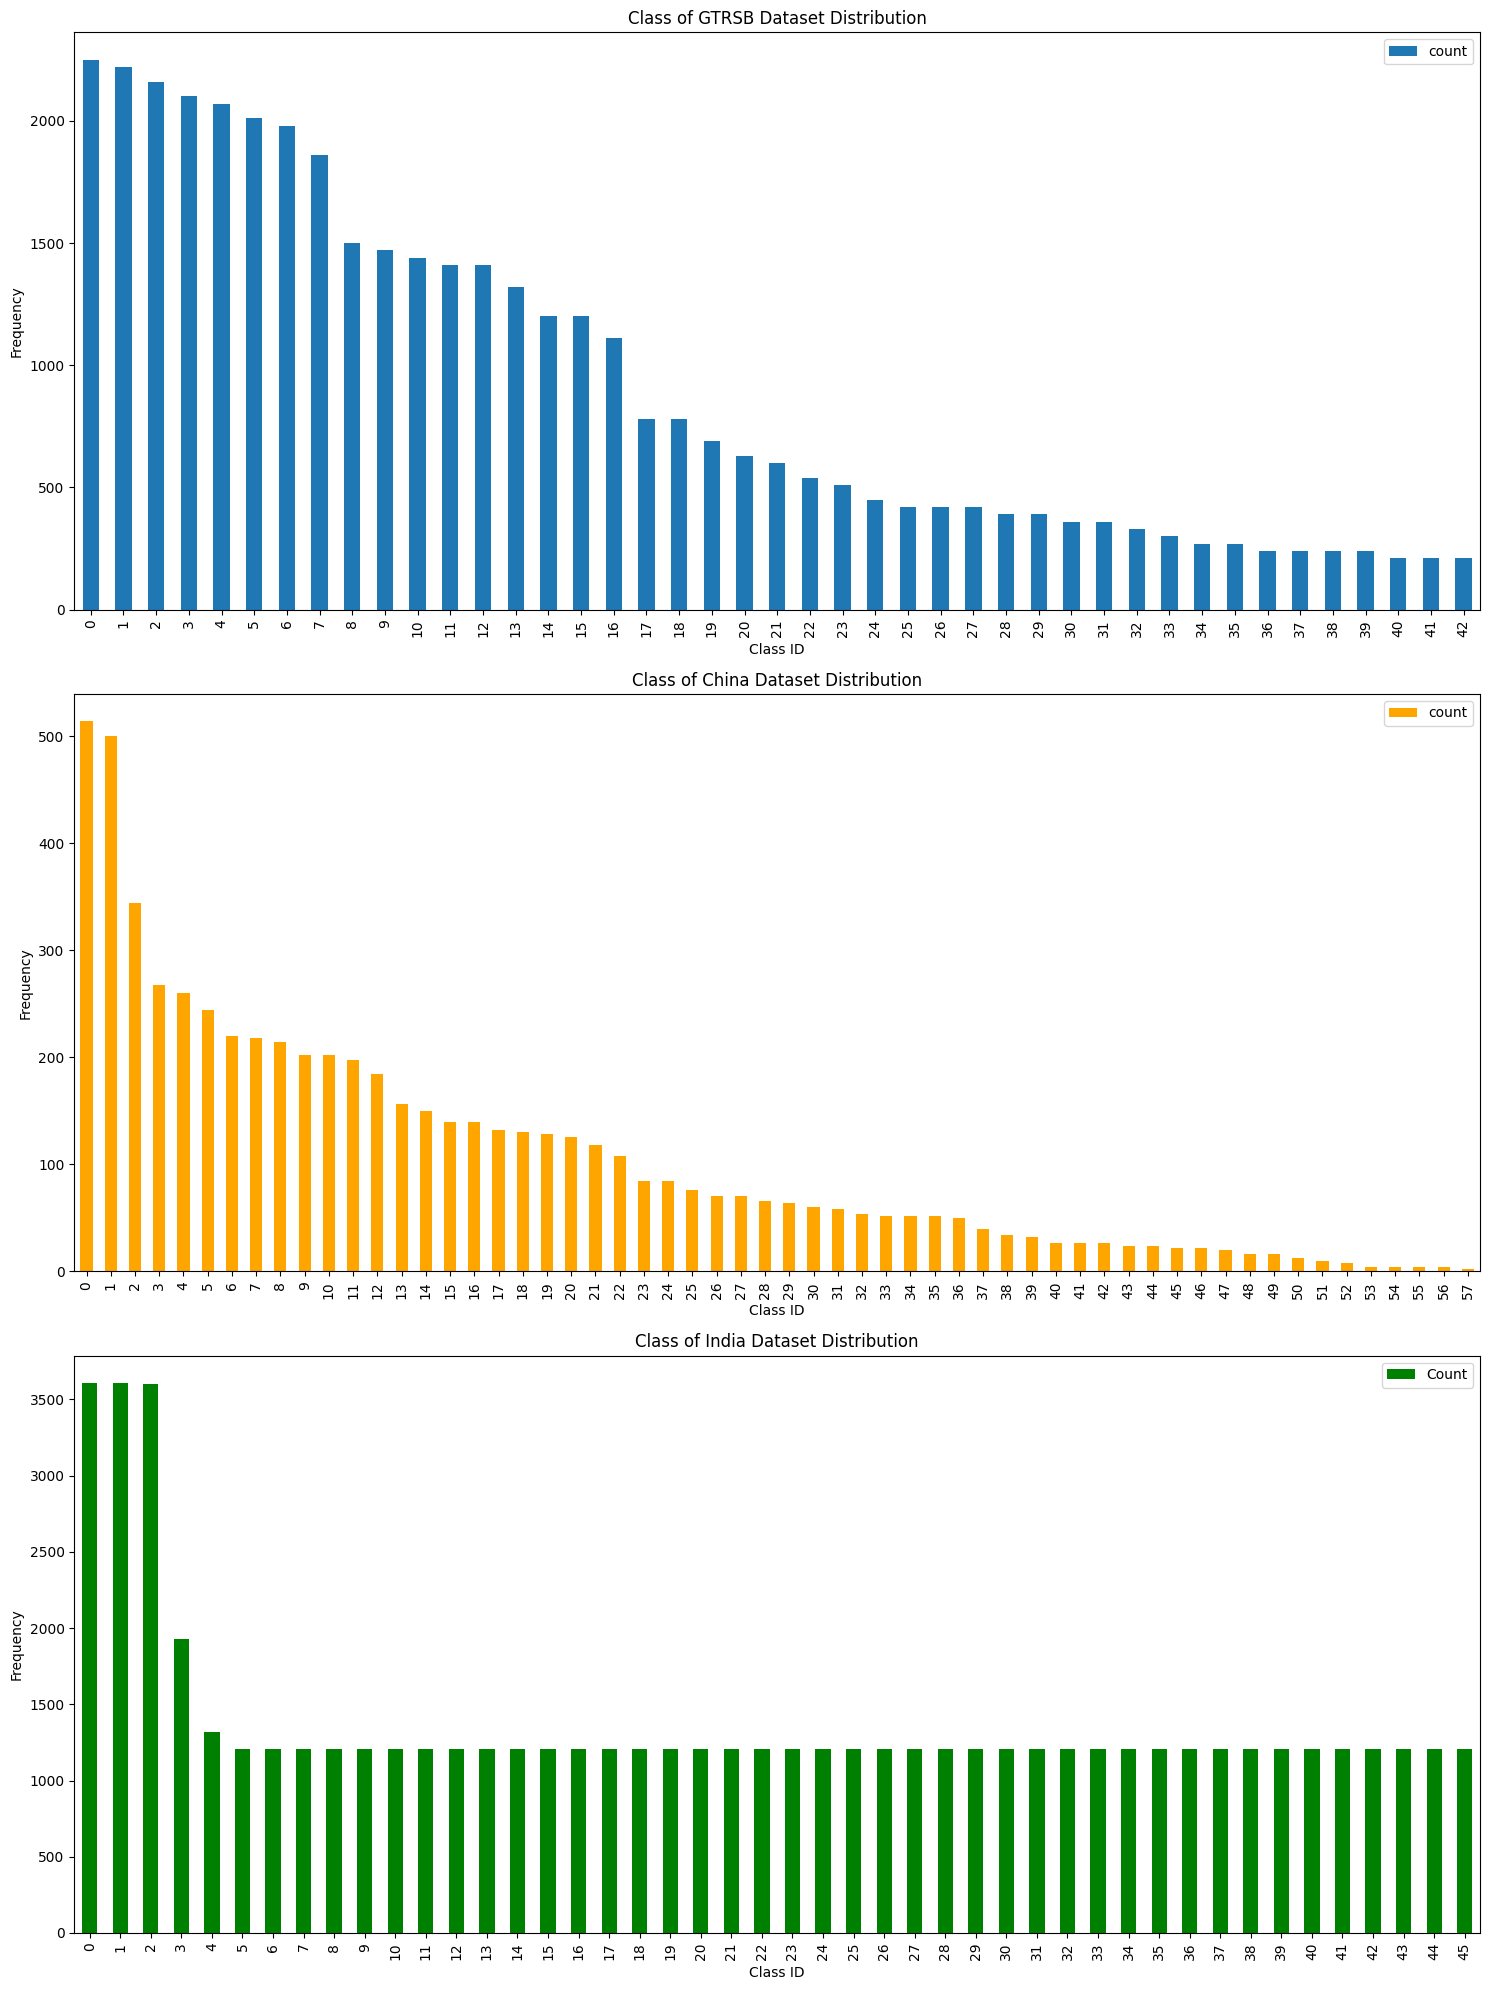

In [184]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

# GTRSB
GTRSB_class_distribution_sorted = GTRSB_class_distribution.sort_index()  
GTRSB_class_distribution_sorted.plot(kind='bar', ax=axs[0])
axs[0].set_title('Class of GTRSB Dataset Distribution')
axs[0].set_xlabel('Class ID')
axs[0].set_ylabel('Frequency')

# China
China_class_distribution_sorted = China_class_distribution.sort_index()  
China_class_distribution_sorted.plot(kind='bar', ax=axs[1], color='orange')
axs[1].set_title('Class of China Dataset Distribution')
axs[1].set_xlabel('Class ID')
axs[1].set_ylabel('Frequency')

# India
India_class_distribution_sorted = India_class_distribution.sort_index()  
India_class_distribution_sorted.plot(kind='bar', ax=axs[2], color='green')
axs[2].set_title('Class of India Dataset Distribution')
axs[2].set_xlabel('Class ID')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Merge GTRSB_class_distribution、China_class_distribution、China_class_distribution

In [185]:
# Merge dataframes
total_class_distribution = pd.merge(GTRSB_class_distribution, China_class_distribution, on='Classes', how='outer')
total_class_distribution = pd.merge(total_class_distribution, India_class_distribution, on='Classes', how='outer')

# Rename columns
total_class_distribution.columns = ['Classes', 'GTRSB_Count', 'China_Count', 'India_Count']

# Sum 'Count' columns
total_class_distribution['Total_Count'] = total_class_distribution[['GTRSB_Count', 'China_Count', 'India_Count']].sum(axis=1)

# Convert 'Total_Count' to integer
total_class_distribution['Total_Count'] = total_class_distribution['Total_Count'].astype(int)

# Select 'Classes' and 'Total_Count' columns
final_class_distribution = total_class_distribution[['Classes', 'Total_Count']]

# Display result
final_class_distribution


,Classes,Total_Count
0,Speed limit (50km/h),2406
1,Speed limit (30km/h),2360
2,Yield,3516
3,Priority road,2100
4,Keep right,2330
...,...,...
102,Axle weight limit,1206
103,Length limit,1206
104,Speed limit (90 km/h),1206
105,Speed limit (110 km/h),1206


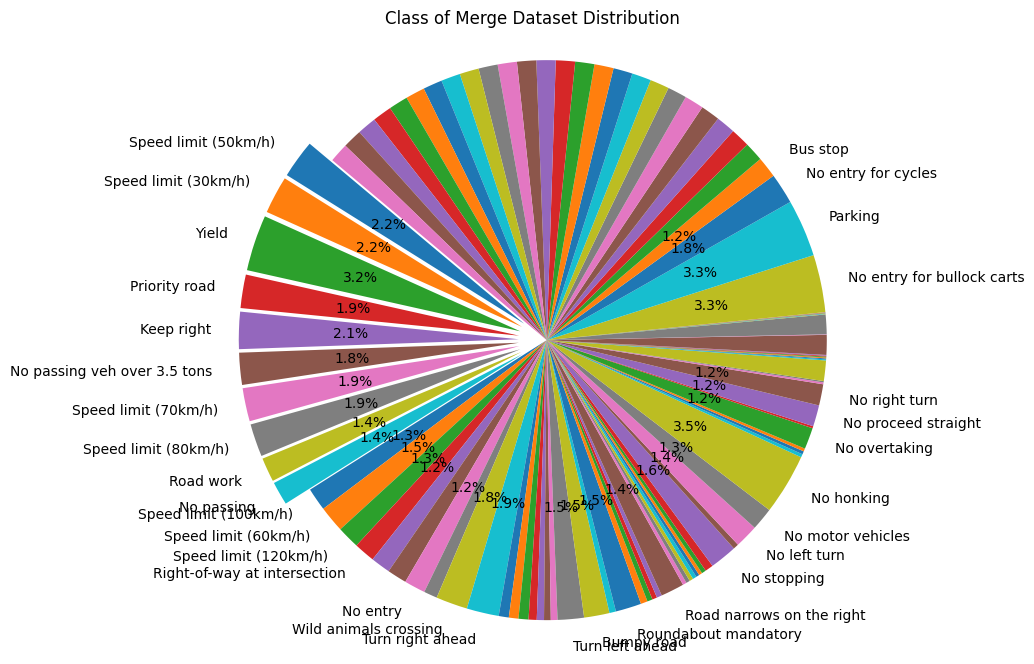

In [186]:
# A pie chart visualizing the proportion of each category, with labels for proportions below 1.2% hidden for aesthetic purposes
# and the top 7 categories highlighted.
labels = final_class_distribution['Classes']
sizes = final_class_distribution['Total_Count']
total = sum(sizes)
percentages = [(size / total) * 100 for size in sizes]
# Create a new explosion array for the first 10 classes
explode = [0.1 if i < 10 else 0 for i in range(len(labels))]

# Plot the pie chart
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)

# Adjust label positions
for i, percentage in enumerate(percentages):
    if percentage <= 1.2:
        autotexts[i].set_text('')  # Do not show labels for parts with less than or equal to 1.5%
        texts[i].set_text('')

# Display the pie chart
plt.axis('equal')  # Ensure it's a circle
plt.title('Class of Merge Dataset Distribution')
plt.show()

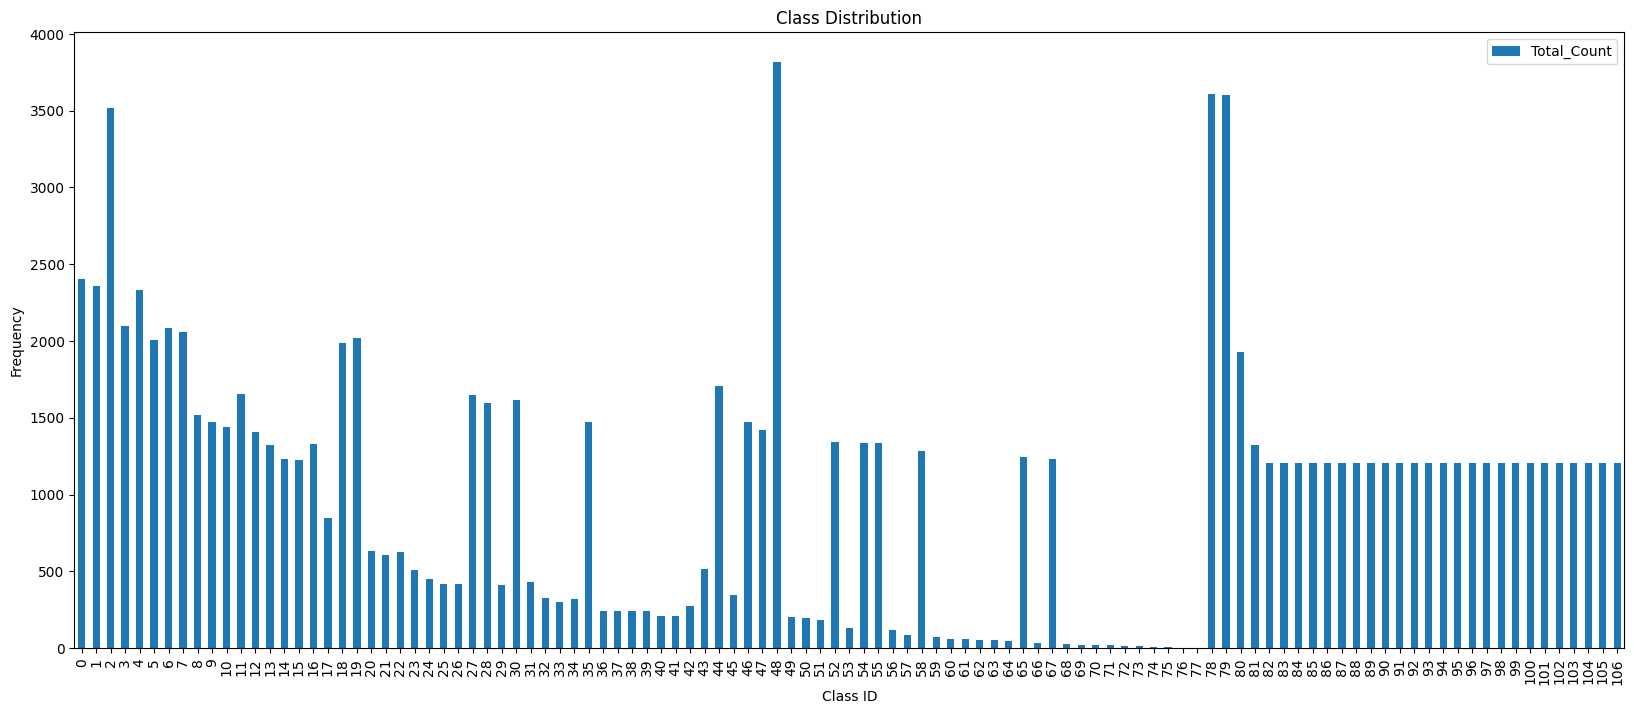

In [187]:
fig, axs = plt.subplots(figsize=(20, 8))  
class_distribution_sorted = final_class_distribution.sort_index()  # Sort the index of category distribution.
class_distribution_sorted.plot(kind='bar', ax=axs)
axs.set_title('Class Distribution')
axs.set_xlabel('Class ID')
axs.set_ylabel('Frequency')
plt.show()


### The number of categories in the dataset is inconsistent, especially in Chinese datasets where the category numbers vary greatly. This may have an impact on neural network learning algorithms:

- Skewed Classification: When the number of samples in one category far exceeds that of others, machine learning algorithms might tend to allocate more samples to this category, resulting in skewed classification results. This is because the algorithm tends to assign samples to larger categories to minimize the overall error rate.

- Imbalanced Model Evaluation: When evaluating model performance, if the number of samples in each category is uneven, simply using accuracy as an evaluation metric could be misleading. For instance, if a category has very few samples, but the algorithm can accurately predict this category, then the accuracy might be high, but in reality, the model's performance on other categories might be poor.

- Feature Bias: When the number of samples in a category in a dataset is small, machine learning algorithms might struggle to learn the feature patterns of that category. This could lead to inferior performance when predicting this category.

To address these impacts, several strategies can be implemented:

- Resampling techniques: Resampling techniques involve either undersampling (randomly deleting samples from the majority class) or oversampling (duplicating samples from the minority class) to balance the sample sizes of different classes in a dataset. This can make the sample sizes of each class more balanced, thereby reducing the problem of skewed classification.

- Class weight adjustment: In some machine learning algorithms, different weights can be assigned to different classes to balance the differences in sample sizes between classes. This allows the algorithm to pay more attention to the minority class, thereby improving its predictive ability for the minority class.

- Using appropriate evaluation metrics: In addition to accuracy, other evaluation metrics such as precision, recall, and F1 score can be used to assess the performance of a model. These metrics are more sensitive to imbalanced datasets and can better measure the performance of the model on each class.
---